In [183]:
import numpy as np
import matplotlib.pyplot as plt

In [184]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

In [185]:
def safe_spacing_rhs(vf0, vl0, s0, tau, bf, hat_b):
    return 0.5 * (vf0 * tau + vl0**2 / hat_b + bf * tau**2)

In [186]:
def simulate(vf0, vl0, s0, tau, bf, bl, sl=5.0,
             T_max=10.0, dt=0.01):

    t = np.arange(0.0, T_max + dt, dt)

    x_f = np.zeros_like(t)
    x_l = np.zeros_like(t)
    gap = np.zeros_like(t)


    x_f0 = 0.0
    x_l0 = s0 + sl  

 
    if vl0 > 0 and bl < 0:
        t_stop_l = vl0 / abs(bl)
        d_l_stop = vl0 * t_stop_l + 0.5 * bl * t_stop_l**2
        x_l_stop = x_l0 + d_l_stop
    else:
        t_stop_l = 0.0
        x_l_stop = x_l0


    if vf0 > 0 and bf < 0:
        t_stop_f_rel = vf0 / abs(bf)  
        d_f_brake = vf0 * t_stop_f_rel + 0.5 * bf * t_stop_f_rel**2
        x_f_stop = x_f0 + vf0 * tau + d_f_brake
    else:
        t_stop_f_rel = 0.0
        x_f_stop = x_f0

    collision = False
    t_collision = None

    for i, ti in enumerate(t):
      
        if ti <= t_stop_l:
            x_l[i] = x_l0 + vl0 * ti + 0.5 * bl * ti**2
        else:
            x_l[i] = x_l_stop

    
        if ti <= tau:
            x_f[i] = x_f0 + vf0 * ti
        else:
            t2 = ti - tau
            if t2 <= t_stop_f_rel:
                x_f[i] = x_f0 + vf0 * tau + vf0 * t2 + 0.5 * bf * t2**2
            else:
                x_f[i] = x_f_stop

     
        gap[i] = (x_l[i] - sl) - x_f[i]

        if (not collision) and gap[i] <= 0:
            collision = True
            t_collision = ti

    return t, x_f, x_l, gap, collision, t_collision

In [187]:
rng = np.random.default_rng(seed=5)

In [188]:
found_safe = False
num_trials = 10000

In [189]:
for trial in range(num_trials):

    tau = 2.0 / 3.0


    a_l = rng.normal(1.7, 0.3)       
    bl = -2.0 * a_l                  
    sl = rng.normal(6.5, 0.3)      
    V_l = rng.normal(20.0, 3.2)      


    a_f = rng.normal(1.7, 0.3)
    bf = -2.0 * a_f                

  
    if not (bf < bl < 0):
        continue

    V_f = rng.normal(20.0, 3.2)


    vf0 = max(0.0, V_f + rng.uniform(2.0, 8.0))
    vl0 = max(0.0, V_l - rng.uniform(0.0, 4.0))
    if vf0 <= vl0:
        continue

    s0 = rng.uniform(20.0, 80.0)
    hat_b = min(-3.0, (bl - 3.0) / 2.0)
    rhs = safe_spacing_rhs(vf0, vl0, s0, tau, bf, hat_b)

    t, x_f, x_l, gap, collision, t_coll = simulate(
        vf0, vl0, s0, tau, bf, bl, sl=sl, T_max=20.0, dt=0.01
    )

    min_gap = gap.min()

    if (not collision) and (min_gap > 0.5):
        found_safe = True
        print("no collion case found with the following values at trial:", trial)
        print(f"vf0 = {vf0:.2f} m/s")
        print(f"vl0 = {vl0:.2f} m/s")
        print(f"s0  = {s0:.2f} m")
        print(f"tau = {tau:.2f} s")
        print(f"bf  = {bf:.2f} m/s^2")
        print(f"bl  = {bl:.2f} m/s^2")
        print(f"sl  = {sl:.2f} m")
        print(f"hat_b = {hat_b:.2f} m/s^2")
        print(f"rhs from inequality = {rhs:.2f} m")
        print(f"s0 - rhs = {s0 - rhs:.2f} m")
        print(f"min gap ≈ {min_gap:.2f} m")
        break

if not found_safe:
    print("no safe example found in", num_trials, "trials")


no collion case found with the following values at trial: 16
vf0 = 23.98 m/s
vl0 = 21.49 m/s
s0  = 53.20 m
tau = 0.67 s
bf  = -3.18 m/s^2
bl  = -2.68 m/s^2
sl  = 6.12 m
hat_b = -3.00 m/s^2
rhs from inequality = -69.68 m
s0 - rhs = 122.88 m
min gap ≈ 33.09 m


In [190]:
tau = 2.0 / 3.0

In [191]:
theta = tau / 2.0 

In [192]:
t, x_f, x_l, gap, collision, t_coll = simulate(
    vf0, vl0, s0, tau, bf, bl, sl=sl, T_max=20.0, dt=0.01
)


In [193]:
print("Collision:", collision)
print("Minimum gap:", gap.min(), "m")


Collision: False
Minimum gap: 33.08652939596148 m


In [194]:
idx_min = gap.argmin()
t_min = t[idx_min]
g_min = gap[idx_min]

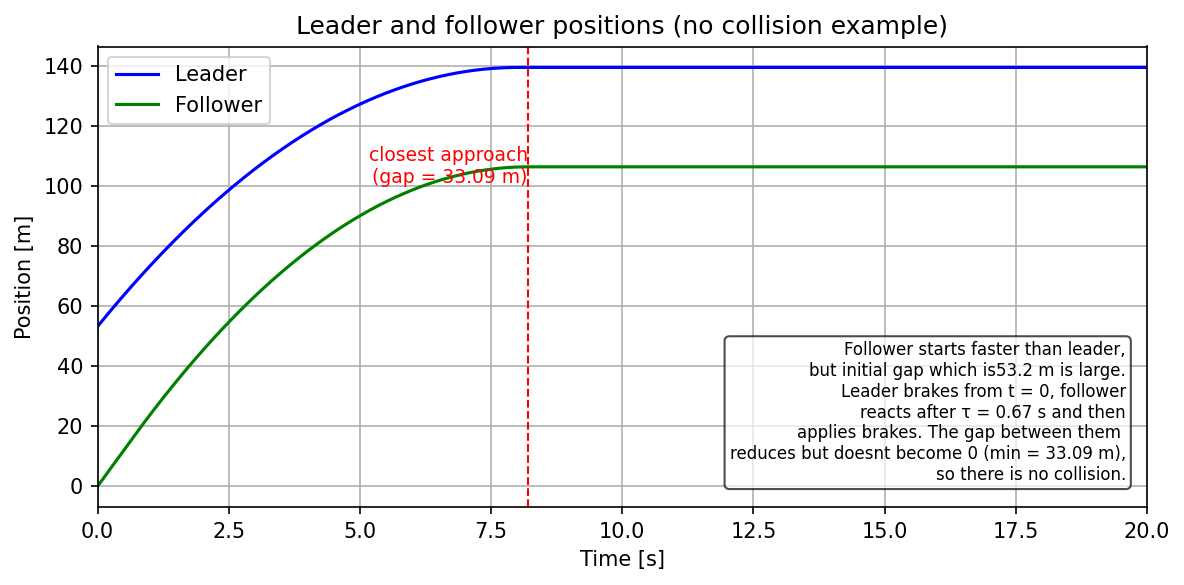

In [195]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)


ax.plot(t, x_l - sl, label="Leader", color  = 'blue')
ax.plot(t, x_f,      label="Follower", color = "green")


ax.axvline(t_min, linestyle="--", color="red", linewidth=1)

ax.text(
    t_min,
    x_f[idx_min],
    f"closest approach\n(gap = {g_min:.2f} m)",
    fontsize=9,
    color="red",
    ha="right",
    va="center",
)

text_box = (
    f"Follower starts faster than leader,\n"
    f"but initial gap which is{s0:.1f} m is large.\n"
    f"Leader brakes from t = 0, follower\n"
    f"reacts after τ = {tau:.2f} s and then\n"
    f"applies brakes. The gap between them \n"
    f"reduces but doesnt become 0 (min = {g_min:.2f} m),\n"
    f"so there is no collision."
)

ax.text(
    0.98, 0.05,             
    text_box,
    transform=ax.transAxes,
    fontsize=8,
    ha="right",
    va="bottom",        
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
)

ax.set_xlim(0, 20.0)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [m]")
ax.set_title("Leader and follower positions (no collision example)")
ax.legend()

plt.tight_layout()
plt.show()
